In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt




from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder



In [3]:
#reading data from train.csv in dataset folder 
def read_data(file_path):    
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

In [4]:
# Read the training data
train_data = read_data('/kaggle/input/machine-learning-dataset/train.csv')
if train_data is not None:
    print("Data loaded successfully!")

Data loaded successfully!


In [5]:
def preprocess_data():
    train_data = read_data('/kaggle/input/machine-learning-dataset/train.csv')
    if train_data is not None:
        print("Data loaded successfully!")
    # Handle categorical variables
    categorical_columns = ['Gender', 'City', 'Working Professional or Student', 
                          'Profession', 'Sleep Duration', 'Dietary Habits', 
                          'Degree', 'Have you ever had suicidal thoughts ?',
                          'Family History of Mental Illness']
    label_encoders = {}
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        train_data[column] = label_encoders[column].fit_transform(train_data[column].fillna('Missing'))
    numerical_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
                    'Financial Stress']
    for column in numerical_columns:
        train_data[column] = train_data[column].fillna(train_data[column].median())
    X = train_data.drop(['id', 'Name', 'Depression'], axis=1)
    y = train_data['Depression']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


# ZeroR

In [5]:
from sklearn.dummy import DummyClassifier, DummyRegressor

X_train, X_test, y_train, y_test = preprocess_data()

# For classification
zero_r_classifier = DummyClassifier(strategy="most_frequent")
zero_r_classifier.fit(X_train, y_train)
y_pred = zero_r_classifier.predict(X_test)


#  Print predictions
print("Predictions:", y_pred)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Data loaded successfully!
Predictions: [0 0 0 ... 0 0 0]
Confusion Matrix:
[[22986     0]
 [ 5154     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     22986
           1       0.00      0.00      0.00      5154

    accuracy                           0.82     28140
   macro avg       0.41      0.50      0.45     28140
weighted avg       0.67      0.82      0.73     28140



e:\SSD\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\SSD\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\SSD\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Stratified Model(Baseline)

In [6]:
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = preprocess_data()

# Create a Stratified dummy classifier
stratified_model = DummyClassifier(strategy="stratified")
stratified_model.fit(X_train, y_train)

y_pred = stratified_model.predict(X_test)


#  Print predictions
print("Predictions:", y_pred)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Data loaded successfully!
Predictions: [0 1 0 ... 0 0 1]
Confusion Matrix:
[[18800  4186]
 [ 4158   996]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     22986
           1       0.19      0.19      0.19      5154

    accuracy                           0.70     28140
   macro avg       0.51      0.51      0.51     28140
weighted avg       0.70      0.70      0.70     28140



# SVM

In [ ]:
#use svm to be trained on these data
# Import necessary libraries

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Print model performance
print("\nModel Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:

# print("\nFeature Importance (approximation):")
# # SVMs don't have true feature importance, but we can estimate using permutation importance
# from sklearn.inspection import permutation_importance

# result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
# importance_scores = result.importances_mean
# for i, score in enumerate(importance_scores):
#     print(f"Feature {i}: Importance Score = {score:.4f}")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Preprocess and scale your data
X_train, X_test, y_train, y_test = preprocess_data()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Create a linear SVM model
linear_svc = SVC(kernel='linear', random_state=42, probability=True)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=linear_svc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test_scaled)

print("\n✅ Best C value:", grid_search.best_params_['C'])
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time


# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of kernels to try
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Dictionary to store results
results = {}

for kernel in kernels:
    # Create and train model
    print(f"\nTraining SVM with {kernel} kernel...")
    start_time = time.time()
    
    svm_model = SVC(
        kernel=kernel,
        random_state=42,
        probability=True  # Enable probability estimates
    )
    
    # Fit model
    svm_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test_scaled)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results[kernel] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': training_time,
        'report': classification_report(y_test, y_pred)
    }
    
    print(f"\nResults for {kernel} kernel:")
    print(f"Accuracy: {results[kernel]['accuracy']:.4f}")
    print(f"Training time: {results[kernel]['training_time']:.2f} seconds")
    print("\nClassification Report:")
    print(results[kernel]['report'])

Data loaded successfully!

Training SVM with linear kernel...

Results for linear kernel:
Accuracy: 0.9362
Training time: 722.01 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.84      0.81      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140


Training SVM with rbf kernel...

Results for rbf kernel:
Accuracy: 0.9360
Training time: 693.46 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22986
           1       0.85      0.79      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.94     28140


Training SVM with poly kernel...

Results for poly kern

# Random Forest

Data loaded successfully!

Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.84      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.89      0.90      0.89     28140
weighted avg       0.94      0.94      0.94     28140



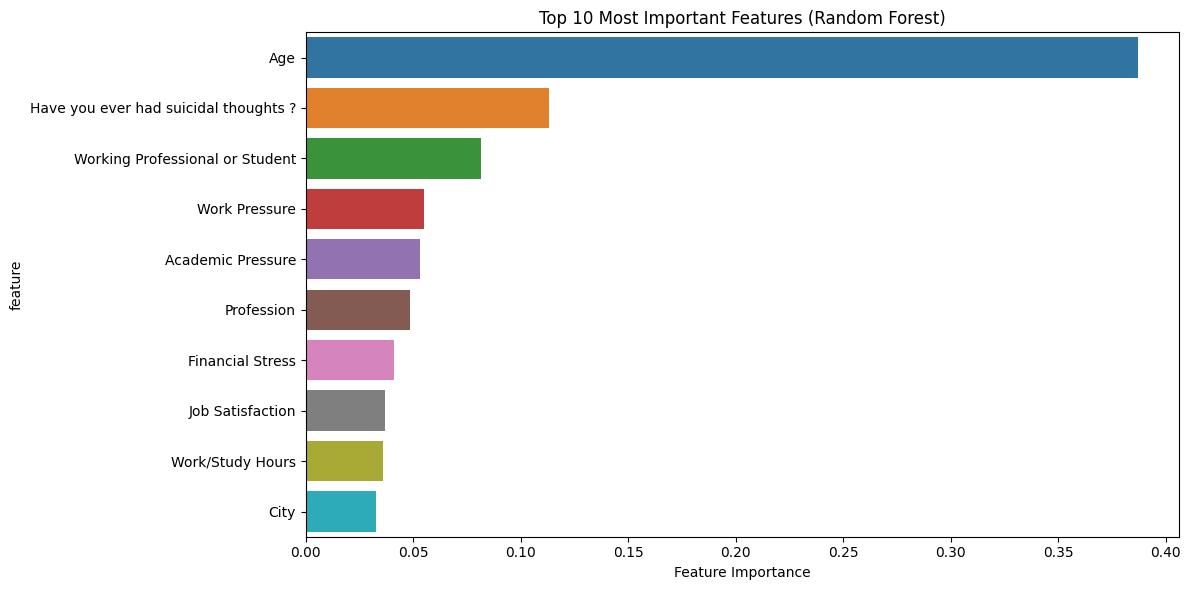


Top 10 Most Important Features:
                                  feature  importance
1                                     Age    0.387097
13  Have you ever had suicidal thoughts ?    0.113149
3         Working Professional or Student    0.081522
6                           Work Pressure    0.054889
5                       Academic Pressure    0.053162
4                              Profession    0.048749
15                       Financial Stress    0.040955
9                        Job Satisfaction    0.036874
14                       Work/Study Hours    0.035882
2                                    City    0.032504


In [6]:
# Import necessary libraries

#Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


X_train, X_test, y_train, y_test = preprocess_data()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,    # Number of trees in the forest
    max_depth=20,        # Maximum depth of each tree
    min_samples_split=5, # Minimum samples required to split a node
    min_samples_leaf=1,  # Minimum samples required at each leaf node
    random_state=42,
    class_weight='balanced' # Handle class imbalance
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print model performance
print("\nRandom Forest Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print detailed feature importance
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string())


Bias-Variance Analysis:
Training Accuracy (Ein): 0.9847
Testing Accuracy (Eout): 0.9363

Plotting Learning Curve:


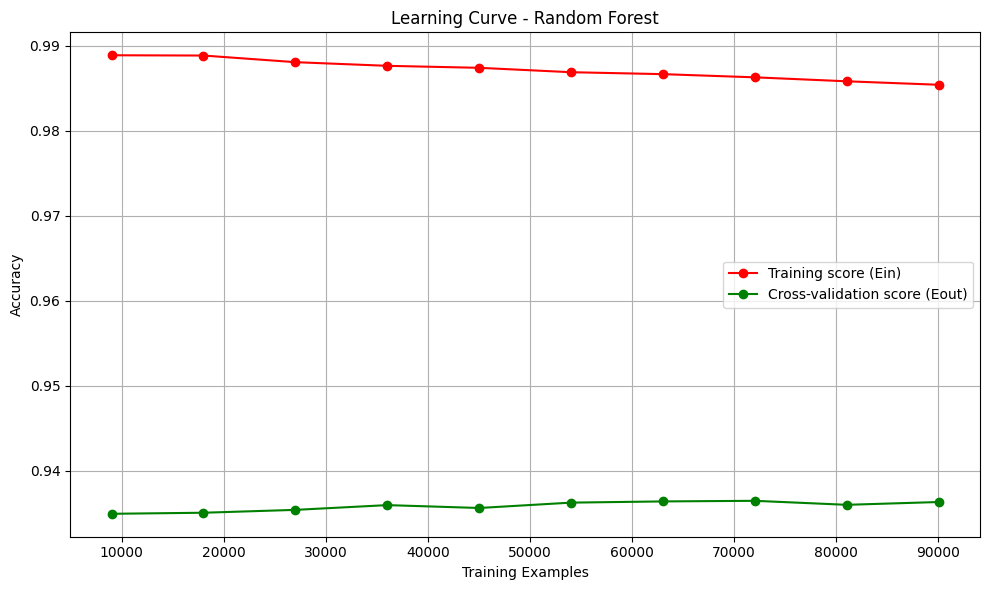

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np


train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"Training Accuracy (Ein): {train_score:.4f}")
print(f"Testing Accuracy (Eout): {test_score:.4f}")

# Interpretation tip:
# If Ein >> Eout → Overfitting
# If Ein ≈ Eout but both low → Underfitting
# If both high → Good generalization

########################################
# Learning Curve (Ein vs Eout)
########################################
print("\nPlotting Learning Curve:")
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, 
    cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score (Ein)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score (Eout)")
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Create Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# Perform grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
# Fit grid search
grid_search.fit(X_train, y_train)
# Get best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Set up cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
n_classes = len(np.unique(y_train))

# Collect predictions
all_preds = []
all_true = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

   
    # Create and train the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=200,    # Number of trees in the forest
        max_depth=20,        # Maximum depth of each tree
        min_samples_split=5, # Minimum samples required to split a node
        min_samples_leaf=1,  # Minimum samples required at each leaf node
        random_state=42,
        class_weight='balanced' # Handle class imbalance
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    all_preds.append(y_pred)
    all_true.append(y_val.values)

# Convert to arrays
all_preds = np.array(all_preds)
all_true = np.array(all_true)

# Align shape
all_preds = np.swapaxes(all_preds, 0, 1)  # shape: (n_samples, n_splits)
all_true = all_true[0]  # All y_true are the same across splits

# Estimate bias and variance (0-1 loss)
bias = np.mean(np.mean(all_preds != all_true.reshape(-1, 1), axis=1))
variance = np.mean(np.var(all_preds, axis=1))

print(f"\n🔍 Bias (0-1 loss): {bias:.4f}")
print(f"🔁 Variance (across CV folds): {variance:.4f}")



🔍 Bias (0-1 loss): 0.2761
🔁 Variance (across CV folds): 0.1411


# Logistic Regression

Data loaded successfully!

Logistic Regression Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.80      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



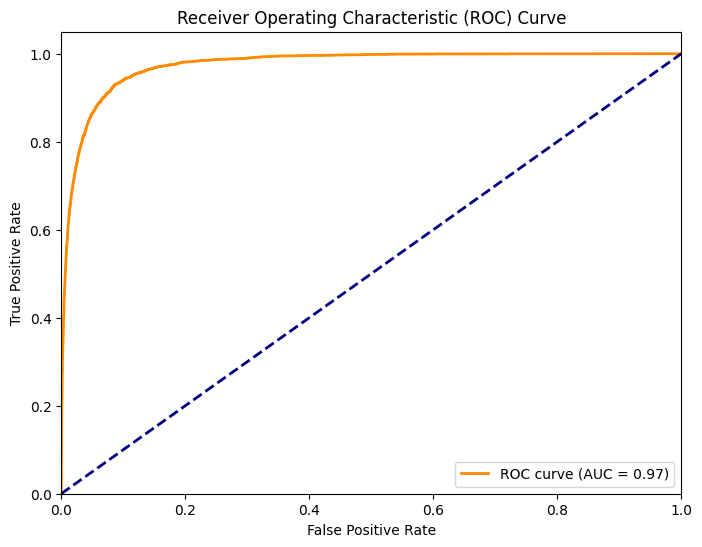

e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


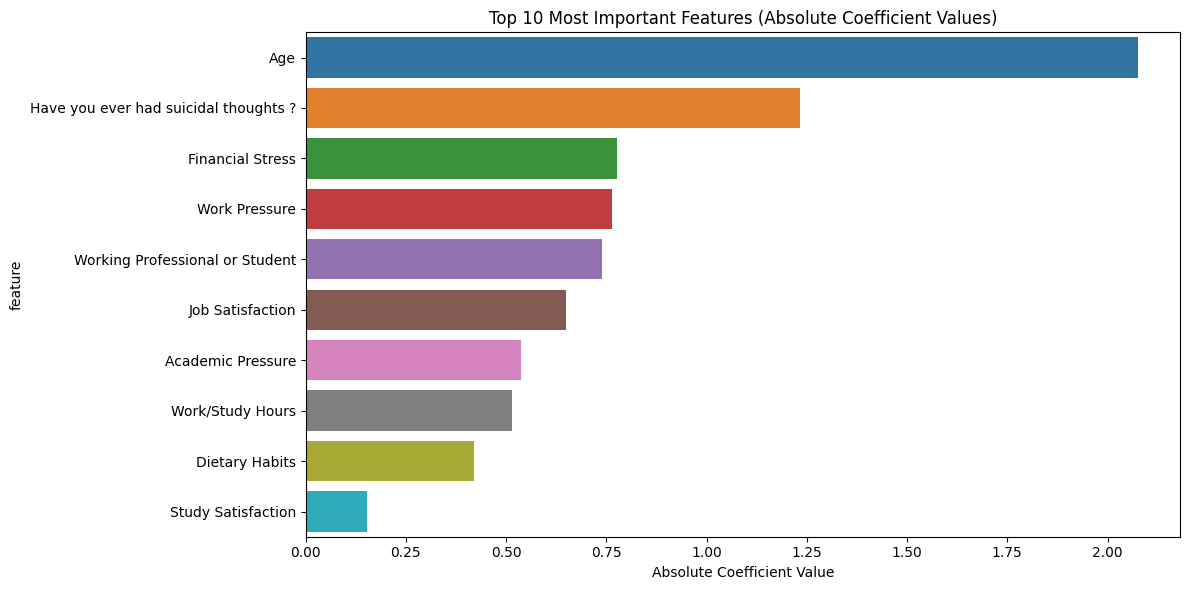


Top 10 Features by Odds Ratio:
                                  feature  odds_ratio  coefficient
13  Have you ever had suicidal thoughts ?    3.429659     1.232461
15                       Financial Stress    2.171382     0.775364
6                           Work Pressure    2.149301     0.765143
5                       Academic Pressure    1.711352     0.537283
14                       Work/Study Hours    1.675047     0.515841
11                         Dietary Habits    1.521259     0.419538
16       Family History of Mental Illness    1.117508     0.111101
7                                    CGPA    1.044964     0.043983
12                                 Degree    1.026048     0.025714
10                         Sleep Duration    1.023994     0.023710


In [10]:
#Best Parameters Found:
# {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000,      
    random_state=42,
    class_weight=None ,
    penalty='l1',
    solver='saga',
    C=0.1
)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nLogistic Regression Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='coefficient', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Absolute Coefficient Values)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Print odds ratios for interpretability
odds_ratios = pd.DataFrame({
    'feature': X_train.columns,
    'odds_ratio': np.exp(lr_model.coef_[0]),
    'coefficient': lr_model.coef_[0]
})
odds_ratios = odds_ratios.sort_values('odds_ratio', ascending=False)

print("\nTop 10 Features by Odds Ratio:")
print(odds_ratios.head(10).to_string())

In [7]:
from sklearn.model_selection import GridSearchCV

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],              # Type of regularization
    'solver': ['liblinear', 'saga'],      # solvers supporting l1 and l2
    'class_weight': [None, 'balanced']    # Try both
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lr_model = grid_search.best_estimator_

# Predict
y_pred = best_lr_model.predict(X_test_scaled)
y_pred_proba = best_lr_model.predict_proba(X_test_scaled)[:, 1]

# After fitting grid_search
print("\nBest Parameters Found:")
print(grid_search.best_params_)


Data loaded successfully!
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters Found:
{'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


# Adaboost

Data loaded successfully!

AdaBoost Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.82      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140



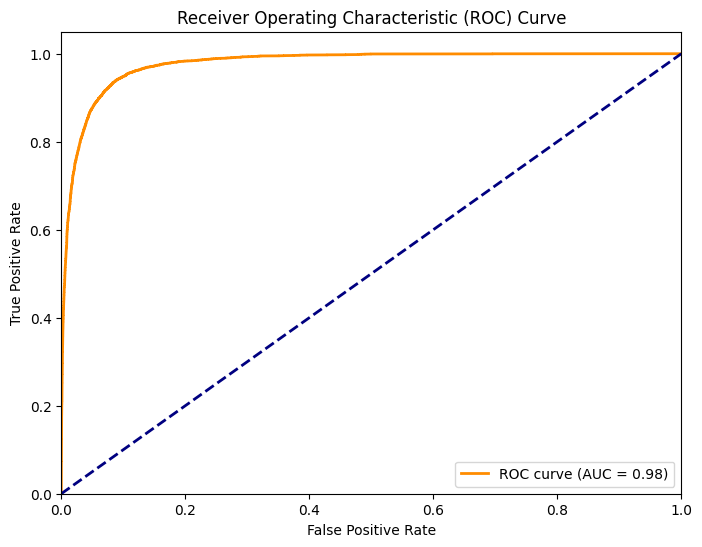

e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\SSD\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


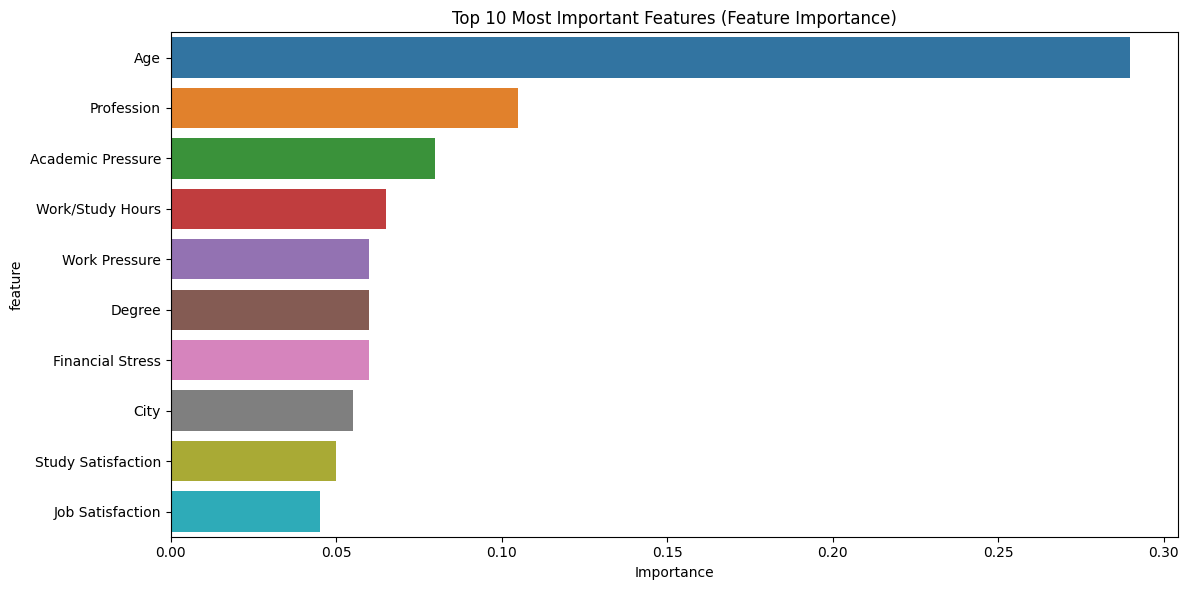


Top 10 Features by Importance:
           feature  importance
               Age       0.290
        Profession       0.105
 Academic Pressure       0.080
  Work/Study Hours       0.065
     Work Pressure       0.060
            Degree       0.060
  Financial Stress       0.060
              City       0.055
Study Satisfaction       0.050
  Job Satisfaction       0.045


In [20]:
#Best Parameters Found:
# {'learning_rate': 1.0, 'n_estimators': 200}


from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the AdaBoost model
ab_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)
ab_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ab_model.predict(X_test_scaled)
y_pred_proba = ab_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nAdaBoost Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': ab_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Feature Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10).to_string(index=False))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = preprocess_data()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# --- Grid Search for AdaBoost Hyperparameter Tuning ---
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Set up GridSearchCV with AdaBoostClassifier
grid_search = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Print best hyperparameters and best ROC AUC score
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("\nBest ROC AUC Score:")
print(grid_search.best_score_)

# Use the best estimator from GridSearchCV for further evaluation
best_ab_model = grid_search.best_estimator_

# --- Evaluation using the Best AdaBoost Model ---
# Make predictions
y_pred = best_ab_model.predict(X_test_scaled)
y_pred_proba = best_ab_model.predict_proba(X_test_scaled)[:, 1]

# Print model performance
print("\nAdaBoost Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_ab_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Feature Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 features by importance
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10).to_string(index=False))
